In [1]:
import sqlite3
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss

%matplotlib widget

In [10]:
results_db = 'results/out_1.9e-12_1.0e-01_True_6.0e+01.db'


In [11]:
dbcon = sqlite3.connect(results_db)
dbcur = dbcon.cursor()
res = dbcur.execute("SELECT * FROM sims").fetchall()

In [ ]:
sim_data = np.array(res, dtype=np.longlong)[:, 2:]
# sim_data[0, 1] = 1
sim_data = np.cumsum(sim_data, axis=0)
n_sims = sim_data.shape[0]
n_conflicts = sim_data[-1,1]
sim_data = np.hstack((sim_data, (sim_data[:, 1] / (sim_data[:, 0]/3600))[:, None]))
# sim_data[:,-1][sim_data[:,-1] > 1] = 0.999999999

In [6]:
print(sim_data[:10,:])
res[:10]

[[ 1147.     0.     0.]
 [ 2294.     0.     0.]
 [ 3441.     0.     0.]
 [ 4588.     0.     0.]
 [ 5735.     0.     0.]
 [ 6882.     0.     0.]
 [ 8029.     0.     0.]
 [ 9176.     0.     0.]
 [10323.     0.     0.]
 [11470.     0.     0.]]


[(31961907, 7987078202709979244, 1147, 0),
 (32168881, 8855534638979991142, 1147, 0),
 (32494783, 5309920061624427631, 1147, 0),
 (32400691, 7495454303914548772, 1147, 0),
 (32063563, 4353484559747047309, 1147, 0),
 (32173894, 6437193190877218543, 1147, 0),
 (32524965, 2043219938267098486, 1147, 0),
 (32622604, 1457809926291663832, 1147, 0),
 (32603243, 2790943174541026656, 1147, 0),
 (32360102, 3491250415702425420, 1147, 0)]

In [7]:
# Work out variance fill betweens
p_confs = sim_data[:, 2]
vars = (p_confs * (1 - p_confs)) / range(sim_data.shape[0])
lower_var = p_confs - vars
upper_var = p_confs + vars

/tmp/ipykernel_99087/1438287155.py:3: RuntimeWarning: invalid value encountered in true_divide
  vars = (p_confs * (1 - p_confs)) / range(sim_data.shape[0])


Text(0.5, 1.0, 'uMAC Convergence')

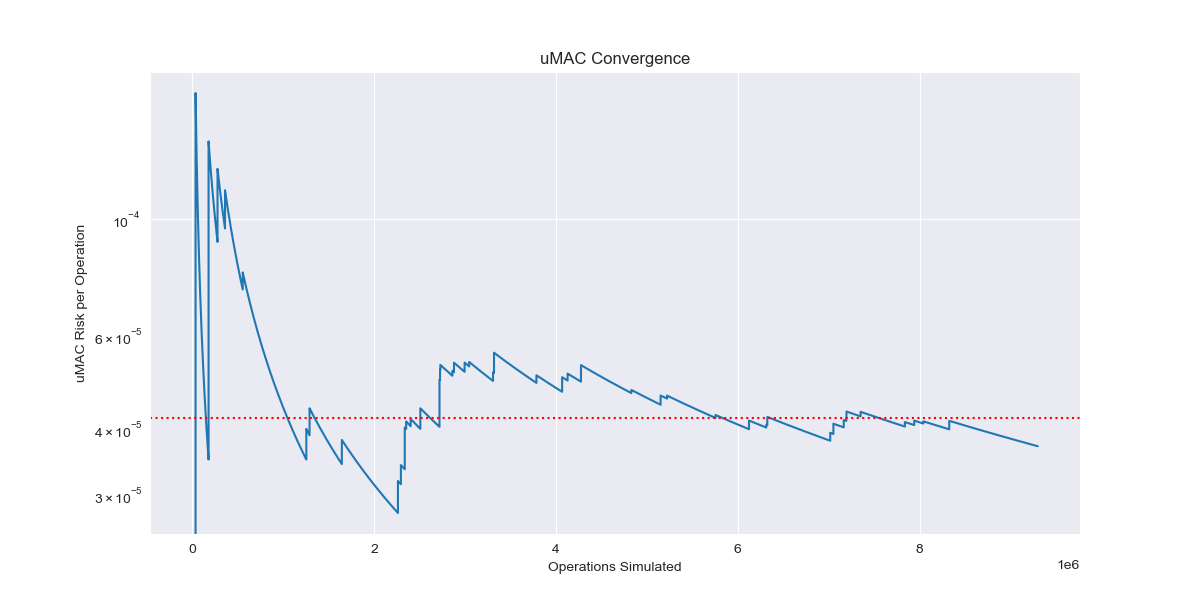

In [9]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.plot(range(sim_data.shape[0]), sim_data[:, 2])
ax.axhline(np.median(sim_data[:,2]), color='red', linestyle=':')
ax.fill_between(range(sim_data.shape[0]), lower_var, upper_var, alpha=.2)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Operations Simulated")
ax.set_ylabel("uMAC Risk per Operation")
ax.set_title("uMAC Convergence")


In [44]:
sim_secs = sim_data[0]
conflict_sum = sim_data[:, 2].sum()
sim_hrs = sim_secs / (60*60)
# sim_hrs = sim_data[:, 1].sum() / (60*60)
sim_ops = sim_data.shape[0]
mean_col_rate = conflict_sum / sim_hrs
median_col_rate = np.median(sim_data[:,2])

/tmp/ipykernel_57730/2933874927.py:6: RuntimeWarning: divide by zero encountered in true_divide
  mean_col_rate = conflict_sum / sim_hrs


In [45]:
raw_sim_data = np.array(res, dtype=np.longlong)[:, 2:]

In [46]:
raw_sim_data.shape

(9300000, 2)

In [47]:
## Binomial distribution analysis
n_hits = raw_sim_data.sum(axis=0)[1]
n_trials = raw_sim_data.shape[0]
est_hit_prob = n_hits/n_trials

var = (est_hit_prob*(1-est_hit_prob))/n_trials
rel_err = np.sqrt(var)/est_hit_prob

# Using the Agresi-Coull method
sig_lvl = 0.05
z = 1-sig_lvl/2
p_til = (n_hits + (z*z)/2)/(n_trials + (z*z))
confidence_err = z*np.sqrt((p_til*(1-p_til))/(n_trials + (z*z)))
print(f'p={sig_lvl} value: {p_til:.3e} +/- {confidence_err} per operation')
print(f'Relative error: {rel_err*100:.4}%')

p=0.05 value: 1.188e-05 +/- 1.1019240518889961e-06 per operation
Relative error: 9.535%
